# Загрузка библиотек

In [1]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from keras.layers import Flatten
from keras import backend as K
import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-2-a0c044f2b17d>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#Вспомогательные функции для визуализации данных

In [3]:
def flatten(train):
  names = []
  for train in train:
    for name in train:
        names.append(name)
  return names

In [4]:
def plot_predictions1(train, valid, predictions, symbol):

  x_train = list(range(0, len(train)))
  x_valid = list(range(len(train)-1, len(valid) + len(train)))

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=x_train, y=flatten(train), mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
  fig.add_trace(go.Scatter(x=x_valid, y=flatten(valid), mode='lines+markers', marker=dict(size=4), name='valid', marker_color='blue'))
  fig.add_trace(go.Scatter(x=x_valid, y=flatten(predictions), mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='red'))
  fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'{symbol} цены на акции', title_x = 0.5,
                  xaxis_title="Дата",
                  yaxis_title="Цены на акции",
                  margin=dict(l=0, r=0, t=30, b=0))
  fig.show()

In [7]:
import yfinance as yf

In [5]:
#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Some functions to help out with
def plot_predictions(train, valid, predictions, symbol):

    plt.plot(valid, color='red',label=f'Real {symbol} Stock Price')
    plt.plot(predictions, color='blue',label=f'Predicted {symbol} Stock Price')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    mse = mean_squared_error(test, predicted)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test, predicted)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(predicted - test)/np.abs(test))
    print('MAPE: '+str(mape))
    return rmse
    
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

In [8]:
stock_name4 = 'IBM'  
data4 = yf.download(stock_name4, start="2023-05-05", end="2023-05-12", interval = "1m").reset_index()
raw_data = data4
print(raw_data)

[*********************100%***********************]  1 of 1 completed
                      Datetime        Open        High         Low  \
0    2023-05-05 09:30:00-04:00  123.110001  123.500000  123.110001   
1    2023-05-05 09:31:00-04:00  123.305000  123.639999  123.239998   
2    2023-05-05 09:32:00-04:00  123.605003  123.730003  123.550003   
3    2023-05-05 09:33:00-04:00  123.589996  123.660004  123.529999   
4    2023-05-05 09:34:00-04:00  123.605003  123.690002  123.550003   
...                        ...         ...         ...         ...   
1934 2023-05-11 15:55:00-04:00  120.919998  120.949997  120.885002   
1935 2023-05-11 15:56:00-04:00  120.925499  120.959999  120.904999   
1936 2023-05-11 15:57:00-04:00  120.925003  120.959999  120.879997   
1937 2023-05-11 15:58:00-04:00  120.900002  120.930000  120.885002   
1938 2023-05-11 15:59:00-04:00  120.900002  120.949997  120.870003   

           Close   Adj Close  Volume  
0     123.305000  123.305000   88659  
1     123.59

#Выгрузка данных

Выгрузка данных происходит иначе по сравнению с другими моделями:

In [9]:
stock_name4 = 'TSLA'  
data = yf.download(stock_name4, start="2023-05-05", end="2023-05-12", interval = "1m").reset_index()
raw_data = data
print(raw_data)

[*********************100%***********************]  1 of 1 completed
                      Datetime        Open        High         Low  \
0    2023-05-05 09:30:00-04:00  163.970001  164.610001  163.509995   
1    2023-05-05 09:31:00-04:00  164.359894  164.449997  164.054993   
2    2023-05-05 09:32:00-04:00  164.044495  164.479996  163.979996   
3    2023-05-05 09:33:00-04:00  164.300003  164.419998  163.869995   
4    2023-05-05 09:34:00-04:00  164.029907  164.979996  163.940002   
...                        ...         ...         ...         ...   
1934 2023-05-11 15:55:00-04:00  172.160004  172.199997  171.759995   
1935 2023-05-11 15:56:00-04:00  171.910004  172.320007  171.830002   
1936 2023-05-11 15:57:00-04:00  172.259995  172.630005  172.229996   
1937 2023-05-11 15:58:00-04:00  172.259995  172.279999  171.839996   
1938 2023-05-11 15:59:00-04:00  171.845001  172.169998  171.789993   

           Close   Adj Close   Volume  
0     164.264999  164.264999  3008840  
1     164.

In [10]:
data = data.filter(['Close'])
dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .80 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
test_data = scaled_data[training_data_len - 8: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(8, len(test_data)):
  x_test.append(test_data[i-8:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
print(x_test.shape)

(387, 8, 1)


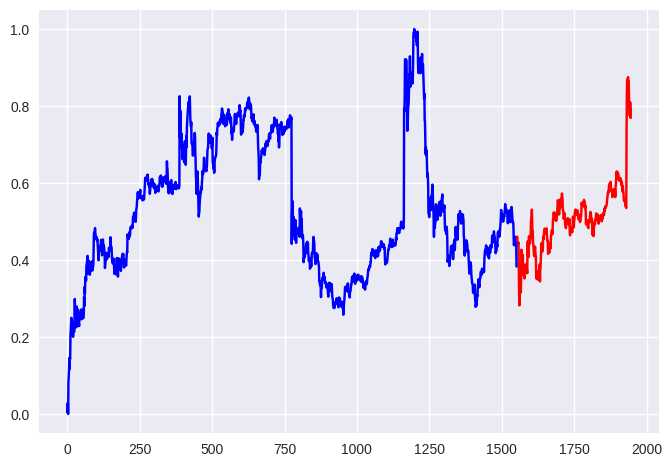

In [12]:
fig, ax = plt.subplots()
plt.plot(list(range(len(train_data), len(train_data) + len(test_data))),test_data, color='red')
plt.plot(list(range(0, len(train_data))),train_data, color='blue')
plt.show()

#Обработка данных

In [13]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaled_data

In [14]:
timesteps = 8
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timesteps, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#Transformer

Энкодер с многоголовочным механизмом внимания

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

Сама модель имеет вид:

In [16]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [17]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5): #30, 100
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# Основная модель

In [18]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [19]:
input_shape = x_train.shape[1:][0], 1

In [20]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=2,
    callbacks=callbacks,
)

Epoch 1/3
772/772 [==============================] - 38s 36ms/step - loss: 0.4204 - mean_squared_error: 0.4204 - val_loss: 0.2982 - val_mean_squared_error: 0.2982 - lr: 1.0000e-06
Epoch 2/3
772/772 [==============================] - 27s 35ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - lr: 3.4300e-05
Epoch 3/3
772/772 [==============================] - 25s 32ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - lr: 6.7600e-05


In [21]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 67ms/step


In [22]:
mse = mean_squared_error(y_test, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - y_test)/np.abs(y_test))
print('MAPE: '+str(mape))

MSE: 0.10991479876963783
MAE: 0.21828222151566537
RMSE: 0.33153400846615694
MAPE: 0.001288993848071947


In [23]:
train = data[:training_data_len]
valid = data[training_data_len - 1:]
train_gr = np.reshape(train, (len(train),))
train_gr = train_gr['Close']
valid_gr = np.reshape(valid, (len(valid),))
valid_gr = valid_gr['Close']
preds_gr = np.reshape(predictions, (len(predictions),))

x_train = list(range(0, len(train_data)+1))
x_valid = list(range(len(train_data), len(dataset)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid', marker_color='blue'))
fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='red'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = 'TSLA цены на акции', title_x = 0.5,
                  xaxis_title="Дата",
                  yaxis_title="Цены на акции",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()